# Extraccion de caracteríticas de los posters

## Tecnicas que se utilizaron:
- HSV
- SIFT
- HU

Cargamos nuestro df

In [35]:
import pandas as pd
import cv2
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import pickle

In [39]:
movies = pd.read_csv('movies_train_with_posters.csv')

In [40]:
movies.head()

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,poster_path
0,619,Ed (1996),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Posterss/Ed (1996).jpg
1,33826,Saint Ralph (2004),Comedy|Drama,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Posterss/Saint Ralph (2004).jpg
2,140289,Men & Chicken (2015),Comedy|Drama,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Posterss/Men & Chicken (2015).jpg
3,2868,Fright Night Part II (1988),Horror,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Posterss/Fright Night Part II (1988).jpg
4,27826,Touch of Pink (2004),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,Posterss/Touch of Pink (2004).jpg


# Histogramas HSV

In [41]:
# Cargar dataset con rutas a los posters
df = pd.read_csv("movies_train_with_posters.csv")

In [ ]:

movie_ids = []
titles = []
histograms = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    img_path = row['poster_path']

    # Verificar existencia
    if not os.path.exists(img_path):
        continue

    img = cv2.imread(img_path)
    if img is None:
        continue

    # Convertir a HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Calcular histogramas
    hist_h = cv2.calcHist([hsv], [0], None, [50], [0, 180])
    hist_s = cv2.calcHist([hsv], [1], None, [60], [0, 256])
    hist_v = cv2.calcHist([hsv], [2], None, [60], [0, 256])

    # Normalizar
    hist_h = cv2.normalize(hist_h, hist_h).flatten()
    hist_s = cv2.normalize(hist_s, hist_s).flatten()
    hist_v = cv2.normalize(hist_v, hist_v).flatten()

    # Concatenar
    hist_concat = np.concatenate([hist_h, hist_s, hist_v])

    movie_ids.append(row['movieId'])
    titles.append(row['title'])
    histograms.append(hist_concat)

# Convertir a array numpy
histograms = np.array(histograms, dtype=np.float32)

# Guardar en binario comprimido
np.savez_compressed(
    "movies_hsv_histograms.npz",
    movie_ids=np.array(movie_ids),
    titles=np.array(titles),
    histograms=histograms
)

print(f"\n✅ Histogramas HSV guardados en 'movies_hsv_histograms.npz'")
print(f"Total de películas procesadas: {len(movie_ids)}")


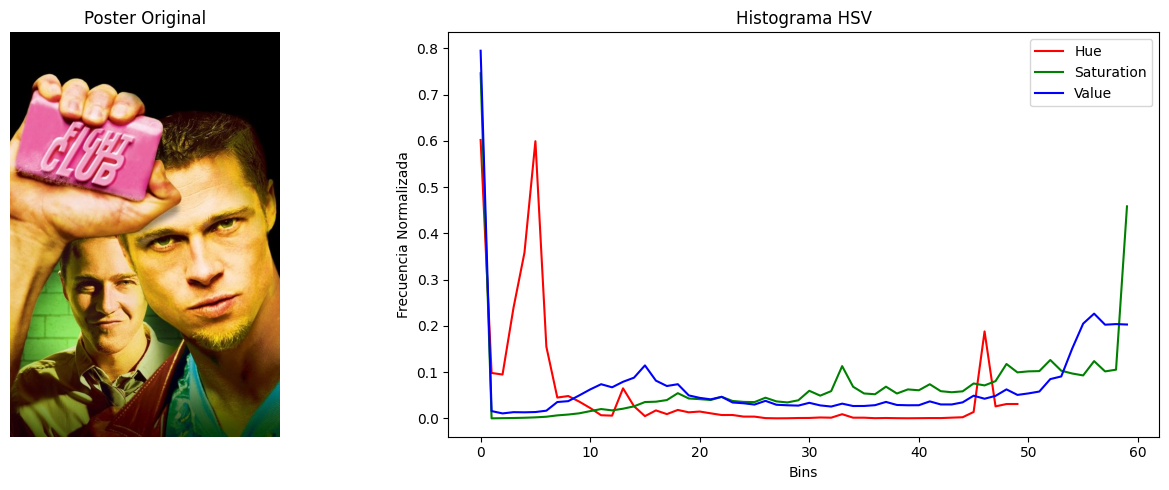

In [6]:
# Ruta de la imagen que quieres analizar
img_path = "Posterss/Fight Club (1999).jpg"  

# Leer la imagen
img = cv2.imread(img_path)

# Validar lectura
if img is None:
    raise ValueError(f"No se pudo leer la imagen: {img_path}")

# Convertir a HSV
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Calcular histogramas para cada canal
hist_h = cv2.calcHist([hsv], [0], None, [50], [0, 180])
hist_s = cv2.calcHist([hsv], [1], None, [60], [0, 256])
hist_v = cv2.calcHist([hsv], [2], None, [60], [0, 256])

# Normalizar (opcional, mejora visualización)
hist_h = cv2.normalize(hist_h, hist_h).flatten()
hist_s = cv2.normalize(hist_s, hist_s).flatten()
hist_v = cv2.normalize(hist_v, hist_v).flatten()

# Graficar
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Poster Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.plot(hist_h, color='r', label='Hue')
plt.plot(hist_s, color='g', label='Saturation')
plt.plot(hist_v, color='b', label='Value')
plt.title("Histograma HSV")
plt.xlabel("Bins")
plt.ylabel("Frecuencia Normalizada")
plt.legend()

plt.tight_layout()
plt.show()

# SIFT

prueba prueba

In [43]:
# Inicializar SIFT
sift = cv2.SIFT_create()

# Diccionarios para guardar datos
movie_ids = []
titles = []
num_keypoints = []
sift_descriptors = {}

# Procesar cada póster
for _, row in tqdm(df.iterrows(), total=len(df)):
    img_path = row["poster_path"]

    # Verificar si la imagen existe
    if not os.path.exists(img_path):
        continue

    img = cv2.imread(img_path)
    if img is None:
        continue

    # Convertir a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detectar y computar descriptores SIFT
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    # Saltar si no hay keypoints
    if descriptors is None:
        continue

    # Guardar resultados
    movie_id = str(row["movieId"])
    movie_ids.append(movie_id)
    titles.append(row["title"])
    num_keypoints.append(len(keypoints))
    sift_descriptors[movie_id] = descriptors.astype(np.float32)

# Crear un diccionario final
sift_data = {
    "movie_ids": np.array(movie_ids),
    "titles": np.array(titles),
    "num_keypoints": np.array(num_keypoints),
    "descriptors": sift_descriptors
}
print("Guardando descriptores SIFT...")
# --- Guardar correctamente con pickle ---
with open("movies_sift_descriptors.pkl", "wb") as f:
    pickle.dump(sift_data, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"\n✅ Descriptores SIFT extraídos para {len(movie_ids)} pósters.")
print("📦 Archivo guardado como 'movies_sift_descriptors.pkl'")


100%|██████████| 5986/5986 [04:06<00:00, 24.31it/s]



Guardando descriptores SIFT...

✅ Descriptores SIFT extraídos para 5831 pósters.
📦 Archivo guardado como 'movies_sift_descriptors.pkl'

✅ Descriptores SIFT extraídos para 5831 pósters.
📦 Archivo guardado como 'movies_sift_descriptors.pkl'


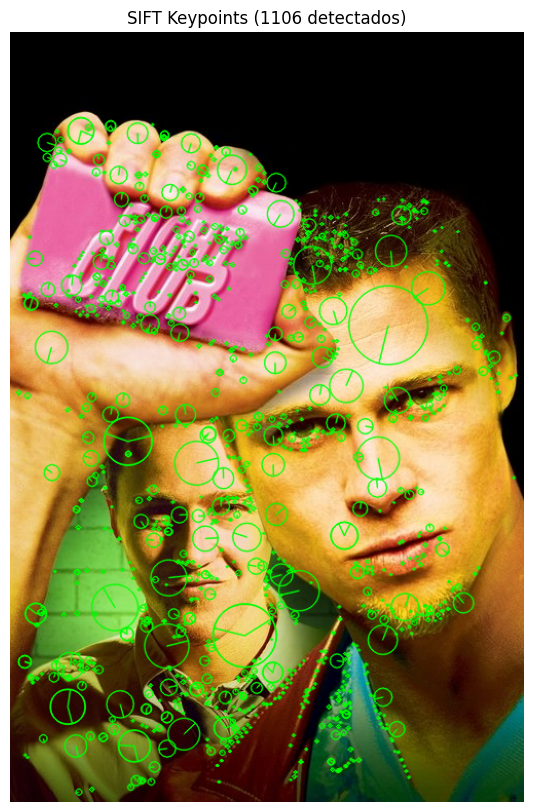

In [45]:
def visualizar_sift_keypoints(img_path):
    """
    Visualiza los keypoints SIFT sobre la imagen original.
    
    Parámetros:
        img_path (str): Ruta de la imagen (póster).
    """
    # Leer imagen
    img = cv2.imread(img_path)
    if img is None:
        print("⚠️ No se pudo cargar la imagen:", img_path)
        return
    
    # Convertir a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Crear el detector SIFT
    sift = cv2.SIFT_create()

    # Detectar keypoints y descriptores
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    # Dibujar keypoints sobre la imagen
    img_keypoints = cv2.drawKeypoints(
        img, keypoints, None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
        color=(0, 255, 0)  # Verde
    )

    # Convertir de BGR a RGB para mostrar correctamente en matplotlib
    img_rgb = cv2.cvtColor(img_keypoints, cv2.COLOR_BGR2RGB)

    # Mostrar la imagen
    plt.figure(figsize=(8, 10))
    plt.imshow(img_rgb)
    plt.title(f"SIFT Keypoints ({len(keypoints)} detectados)")
    plt.axis("off")
    plt.show()


# Ejemplo de uso
visualizar_sift_keypoints("Posterss/Fight Club (1999).jpg")

## Momentos de Hu

In [11]:
# Lista para guardar resultados
hu_features = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    img_path = row["poster_path"]

    # Verificar que el archivo existe
    if not os.path.exists(img_path):
        continue

    # Leer la imagen
    img = cv2.imread(img_path)
    if img is None:
        continue

    # Convertir a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Calcular momentos
    moments = cv2.moments(gray)

    # Calcular momentos de Hu
    hu = cv2.HuMoments(moments).flatten()

    # Aplicar log-transform para mejor estabilidad numérica (opcional, recomendado)
    hu_log = -np.sign(hu) * np.log10(np.abs(hu) + 1e-12)

    # Guardar resultado
    hu_features.append({
        "movieId": row["movieId"],
        "title": row["title"],
        "hu_moments": hu_log
    })

# Convertir a arrays numpy para guardar en formato binario
movie_ids = np.array([d["movieId"] for d in hu_features])
titles = np.array([d["title"] for d in hu_features])
hu_moments = np.array([d["hu_moments"] for d in hu_features])

# Guardar en archivo binario
np.savez_compressed("movies_hu_moments.npz", movieId=movie_ids, title=titles, hu_moments=hu_moments)

print(f"\n✅ Momentos de Hu extraídos para {len(hu_features)} pósters.")
print("📦 Archivo binario guardado como 'movies_hu_moments.npz'")


100%|██████████| 5986/5986 [02:23<00:00, 41.85it/s]



✅ Momentos de Hu extraídos para 5831 pósters.
📦 Archivo binario guardado como 'movies_hu_moments.npz'


In [23]:
def visualizar_momentos_hu(img_path):
    """
    Calcula y muestra los 7 momentos de Hu de una imagen en escala logarítmica.
    """
    # Verificar si existe la imagen
    if not os.path.exists(img_path):
        print(f"❌ No se encontró la imagen: {img_path}")
        return
    
    # Leer imagen
    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ No se pudo abrir la imagen: {img_path}")
        return

    # Convertir a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Calcular momentos y momentos de Hu
    moments = cv2.moments(gray)
    hu = cv2.HuMoments(moments).flatten()

    # Escala logarítmica (más interpretable)
    hu_log = -np.sign(hu) * np.log10(np.abs(hu) + 1e-12)

    # Mostrar imagen y gráfico
    plt.figure(figsize=(12, 4))

    # Imagen original
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Póster Original")
    plt.axis("off")

    # Gráfico de los 7 momentos de Hu
    plt.subplot(1, 2, 2)
    plt.bar(range(1, 8), hu_log, color='skyblue', edgecolor='black')
    plt.title("Momentos de Hu (Escala Logarítmica)")
    plt.xlabel("Momento de Hu")
    plt.ylabel("Valor (log10)")
    plt.xticks(range(1, 8))
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Retornar valores por si se quieren usar luego
    return hu, hu_log

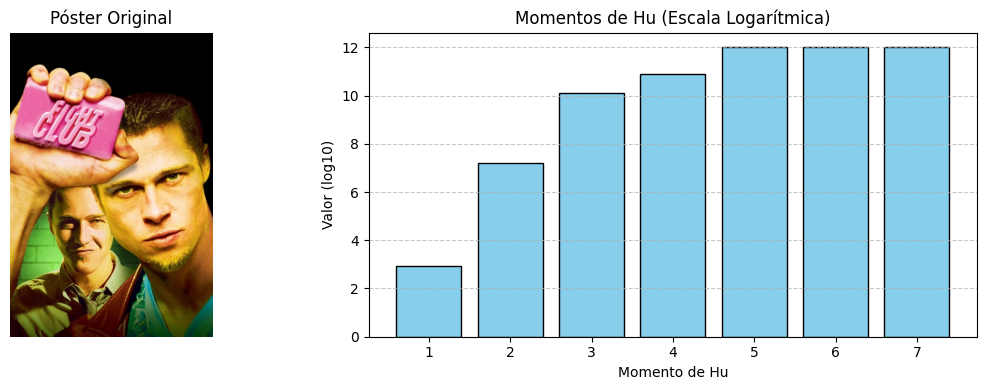

Momentos de Hu: [1.16920305e-03 6.16966812e-08 7.90166662e-11 1.12952635e-11
 2.17492386e-22 2.39845429e-16 2.58005163e-22]


In [24]:
# Ejemplo: visualizar momentos de Hu de una película específica
img_path = "Posterss/Fight Club (1999).jpg"  # reemplaza con el ID real
hu_vals, hu_log = visualizar_momentos_hu(img_path)
print("Momentos de Hu:", hu_vals)

## Combinar los features

In [46]:
# --- Cargar los tres archivos ---
hsv_data = np.load("movies_hsv_histograms.npz", allow_pickle=True)
hu_data = np.load("movies_hu_moments.npz", allow_pickle=True)

# 🔹 Cambia aquí: carga SIFT desde pickle, no desde npz
with open("movies_sift_descriptors.pkl", "rb") as f:
    sift_data = pickle.load(f)

# --- Preparar estructuras homogéneas ---
# HSV
hsv_df = pd.DataFrame({
    "movieId": hsv_data["movie_ids"].astype(str),
    "title": hsv_data["titles"],
    "HSV": list(hsv_data["histograms"])
})

# Hu Moments
hu_df = pd.DataFrame({
    "movieId": hu_data["movieId"].astype(str),
    "title": hu_data["title"],
    "HU": list(hu_data["hu_moments"])
})

# --- SIFT: convertir diccionario en DataFrame y fijar vector ---
sift_features = []
for movie_id in sift_data["movie_ids"]:
    movie_id_str = str(movie_id)
    desc = sift_data["descriptors"].get(movie_id_str)
    if desc is not None and len(desc) > 0:
        sift_features.append(desc.mean(axis=0))
    else:
        sift_features.append(np.zeros(128))  # vector vacío -> ceros

sift_df = pd.DataFrame({
    "movieId": sift_data["movie_ids"].astype(str),
    "title": sift_data["titles"],
    "SIFT": sift_features
})

# --- Combinar por movieId ---
merged = hsv_df.merge(hu_df, on="movieId", how="inner", suffixes=("_hsv", "_hu"))
merged = merged.merge(sift_df, on="movieId", how="inner")

# --- Crear vector combinado ---
combined_features = []
for _, row in tqdm(merged.iterrows(), total=len(merged)):
    combined = np.concatenate([
        row["HSV"],
        row["HU"],
        row["SIFT"]
    ])
    combined_features.append(combined)

merged["features"] = combined_features

# --- Guardar resultado en archivo comprimido ---
np.savez_compressed(
    "movies_combined_features.npz",
    movieId=merged["movieId"].values,
    title=merged["title_hsv"].values,
    features=np.array(merged["features"].tolist(), dtype=np.float32)
)

print(f"\n✅ Archivo combinado guardado como 'movies_combined_features.npz'")
print(f"Total de películas combinadas: {len(merged)}")
print(f"Dimensión final de feature vector: {len(merged['features'][0])}")


100%|██████████| 5831/5831 [00:00<00:00, 25665.93it/s]




✅ Archivo combinado guardado como 'movies_combined_features.npz'
Total de películas combinadas: 5831
Dimensión final de feature vector: 305
